In [14]:
import torch
from torch import nn
from utils_torch import *
import utils_torch as ut

# Queries, Keys, and Values

In [15]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """Show heatmaps of matrices."""
    use_svg_display()
    num_rows, num_cols, _, _ = matrices.shape
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize,
                             sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)

The attention weight is one only when the query and the key are the same.

In [110]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
attention_weights

tensor([[[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]]])

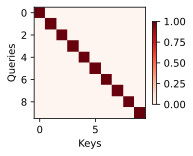

In [111]:
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

# Attention Scoring Functions
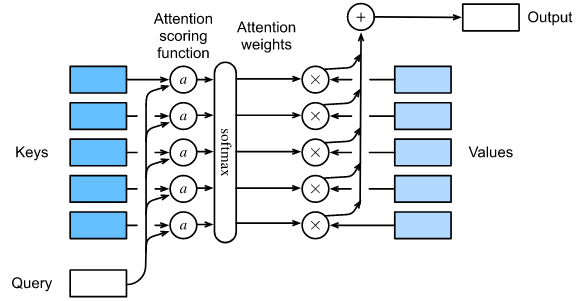

## Dot Product Attention
**Masked Softmax Operation**

In [112]:
def masked_softmax(X, valid_lens):  # @save
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

Consider a minibatch of two examples of size 2x4, where their valid lengths are 2 and 3, respectively. As a result of the masked softmax operation, values beyond the valid lengths for each pair of vectors are all masked as zero. 

In [113]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.6056, 0.3944, 0.0000, 0.0000],
         [0.5626, 0.4374, 0.0000, 0.0000]],

        [[0.3401, 0.2741, 0.3858, 0.0000],
         [0.4247, 0.2250, 0.3503, 0.0000]]])

**Batch Matrix Multiplication**

In [114]:
Q = torch.ones((2, 3, 4))
K = torch.ones((2, 4, 6))
torch.bmm(Q, K), torch.bmm(Q, K).shape

(tensor([[[4., 4., 4., 4., 4., 4.],
          [4., 4., 4., 4., 4., 4.],
          [4., 4., 4., 4., 4., 4.]],
 
         [[4., 4., 4., 4., 4., 4.],
          [4., 4., 4., 4., 4., 4.],
          [4., 4., 4., 4., 4., 4.]]]),
 torch.Size([2, 3, 6]))

## Scaled Dot-Product Attention

In [115]:
class DotProductAttention(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        score = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(score, valid_lens)
        # use dropout for model regularization.
        return torch.bmm(self.dropout(self.attention_weights), values)

In [9]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])
attention = DotProductAttention(dropout=0.5)
attention.eval()

DotProductAttention(
  (dropout): Dropout(p=0.5, inplace=False)
)

In [10]:
attention(queries, keys, values, valid_lens).shape

torch.Size([2, 1, 4])

In [11]:
attention.attention_weights

tensor([[[0.4755, 0.5245, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.1035, 0.1363, 0.2639, 0.0339, 0.3978, 0.0646, 0.0000, 0.0000,
          0.0000, 0.0000]]])

The attention weights actually vanish for anything beyond the second and sixth column respectively (due to setting valid length to 2 and 6).

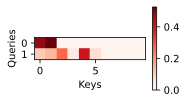

In [12]:
show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
              xlabel='Keys', ylabel='Queries')

## Additive Attention
$$a(\mathbf q, \mathbf k) = \mathbf w_v^\top \text{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R}$$


In [3]:
class AdditiveAttention(nn.Module):
    def __init__(self, num_hiddens, dropout, **kwargs):
        super().__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # queries: (batch_size, no. of queries, num_hiddens)
        # keys: (batch_size, no. of key-value pairs, num_hiddens)

        # dimension expansion:
        # queries: (batch_size, no. of queries, 1, num_hiddens)
        # keys: (batch_size, 1, no. of key-value pairs, num_hiddens)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)

        # There is only one output of self.w_v, so we remove the last
        # one-dimensional entry from the shape.
        # scores: (batch_size, no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values: (batch_size, no. of key-value pairs, value dimension)
        bmm = torch.bmm(self.dropout(self.attention_weights), values)
        return bmm

In [14]:
queries = torch.normal(0, 1, (2, 1, 20))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()

/home/nancy/.local/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


AdditiveAttention(
  (W_k): LazyLinear(in_features=0, out_features=8, bias=False)
  (W_q): LazyLinear(in_features=0, out_features=8, bias=False)
  (w_v): LazyLinear(in_features=0, out_features=1, bias=False)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [15]:
attention(queries, keys, values, valid_lens)

tensor([[[-1.6306e+00, -5.1580e-02, -5.9162e-01,  7.8988e-01]],

        [[ 2.4012e-02, -1.2630e+00,  8.1049e-04,  8.5531e-02]]],
       grad_fn=<BmmBackward0>)

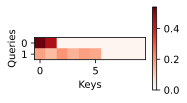

In [16]:
show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
              xlabel='Keys', ylabel='Queries')

# The Bahdanau Attention Mechanism

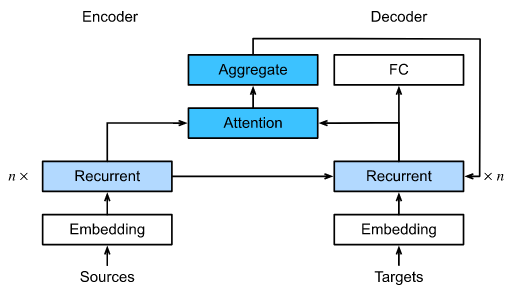

To implement the RNN encoder-decoder with attention, we only need to redefine the decoder

In [4]:
class Seq2SeqAttentionDecoder(Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()
        self.attention = AdditiveAttention(num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens,
                          num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_outputs, enc_valid_lens):
        # outputs: (num_steps, batch_size, num_hiddens)
        # hidden_state: (num_layers, batch_size, num_hiddens)
        outputs, hidden_state = enc_outputs
        return outputs.permute(1, 0, 2), hidden_state, enc_valid_lens

    def forward(self, X, state):
        """ 
        The state of the decoder is initialized with 
        (i) the hidden states of the last layer of the encoder at all time steps, 
            used as keys and values for attention;
        (ii) the hidden state of the encoder at all layers at the final time step. 
            This serves to initialize the hidden state of the decoder;  
        (iii) the valid length of the encoder, to exclude the padding tokens in attention pooling. 
        """
        # enc_outputs: (batch_size, num_steps, num_hiddens)
        # hidden_state: (num_layers, batch_size, num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # output X: (num_steps, batch_size, embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        # x: (batch_size, embed_size)
        # for each step (word)
        for x in X:
            """At each decoding time step, the hidden state of the last layer of the decoder, 
            obtained at the previous time step, is used as the query of the attention mechanism."""
            # hidden_state[-1]: (batch_size, num_hiddens) decoder上一个时刻的最后一层的输出
            # query: (batch_size, 1, num_hiddens)
            #
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # context: (batch_size, 1, num_hiddens)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            """Both the output of the attention mechanism and the input embedding are 
            concatenated to serve as the input of the RNN decoder."""
            # Concatenate on the feature dimension
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # Reshape x as (1, batch_size, embed_size + num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # outputs: (num_steps, batch_size, vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In [18]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 7
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
decoder = Seq2SeqAttentionDecoder(
    vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros((batch_size, num_steps), dtype=torch.long)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)

## Training

In [19]:
data = MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(len(data.src_vocab), embed_size,
                         num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)

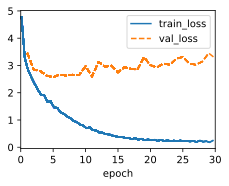

In [20]:
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.005)
trainer = Trainer(max_epochs=30, gradient_clip_val=1)
trainer.fit(model, data)

In [21]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(data.build(engs, fras), cpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['<unk>', '!'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


Let’s visualize the attention weights when translating the last English sentence. We see that each query assigns non-uniform weights over key-value pairs. It shows that at each decoding step, different parts of the input sequences are selectively aggregated in the attention pooling.

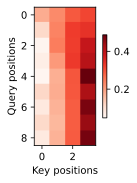

In [22]:
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), cpu(), data.num_steps, True)

attention_weights = torch.cat(
    [step[0][0][0] for step in dec_attention_weights], 0)
attention_weights = attention_weights.reshape((1, 1, -1, data.num_steps))

# Plus one to include the end-of-sequence token
show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')

When predicting a token, if not all the input tokens are relevant, the RNN encoder-decoder with the Bahdanau attention mechanism selectively aggregates different parts of the input sequence. This is achieved by **treating the state (context variable) as an output of additive attention pooling**. 

In the RNN encoder-decoder, the Bahdanau attention mechanism treats the **decoder hidden state at the previous time step** as the ***query***, and the **encoder hidden states at all the time steps** as both the ***keys*** and ***values***.

# Multi-Head Attention

We choose the scaled dot-product attention for each head of the multi-head attention.

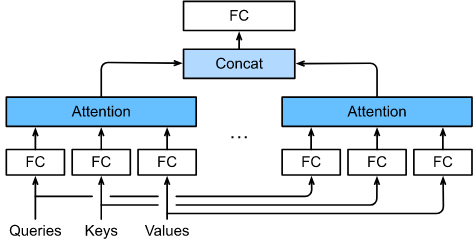

Note that $h$ heads can be computed in parallel if we set the number of outputs of linear transformations for the query, key, and value to $p_qh=p_kh=p_vh=p_o$. In the following implementation, $p_o$ is specified via the argument `num_hiddens`.

In [5]:
class MultiHeadAttention(Module):
    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # Shape of queries, keys, or values:
        # (batch_size, no. of queries or key-value pairs, num_hiddens)
        # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
        # After transposing, shape of output queries, keys, or values:
        # (batch_size * num_heads, no. of queries or key-value pairs, num_hiddens / num_heads)
        queries = self.transpose_qkv(self.W_q(queries))
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))

        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for num_heads
            # times, then copy the next item, and so on
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)
        # output: (batch_size * num_heads, no. of queries, num_hiddens / num_heads)
        output = self.attention(queries, keys, values, valid_lens)
        # output_concat: (batch_size, no. of queries, num_hiddens)
        output_concat = self.transpose_output(output)
        return self.W_o(output_concat)

    # To allow for parallel computation of multiple heads, the above MultiHeadAttention class uses two transposition methods
    def transpose_qkv(self, X):
        """Transposition for parallel computation of multiple attention heads."""
        # input X: (batch_size, no. of queries or key-value pairs,num_hiddens).
        # output X: (batch_size, no. of queries or key-value pairs, num_heads, num_hiddens / num_heads)

        X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)

        # output X: (batch_size, num_heads, no. of queries or key-value pairs, num_hiddens / num_heads)
        X = X.permute(0, 2, 1, 3)

        # output: (batch_size * num_heads, no. of queries or key-value pairs, num_hiddens / num_heads)
        return X.reshape(-1, X.shape[2], X.shape[3])

    #  the transpose_output method reverses the operation of the transpose_qkv method.
    def transpose_output(self, X):
        """Reverse the operation of transpose_qkv."""
        X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
        X = X.permute(0, 2, 1, 3)
        return X.reshape(X.shape[0], X.shape[1], -1)

In [29]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_heads, 0.5)
batch_size, num_queries, num_kvpairs = 2, 4, 6
valid_lens = torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

queries: torch.Size([10, 4, 20]) keys: torch.Size([10, 6, 20]) values: torch.Size([10, 6, 20]) valid_lens: torch.Size([10])


torch.Size([2, 4, 100])

In [25]:
torch.repeat_interleave(valid_lens, repeats=num_heads, dim=0)

tensor([3, 3, 3, 3, 3, 2, 2, 2, 2, 2])

# Self-Attention
Using multi-head attention, the following code snippet computes the self-attention of a tensor with shape (batch size, number of time steps or sequence length in tokens, $d$).
The output tensor has the same shape.

In [33]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(
    num_hiddens=num_hiddens, num_heads=num_heads, dropout=0.5)
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
X. shape, attention(X, X, X, valid_lens).shape

queries: torch.Size([10, 4, 20]) keys: torch.Size([10, 4, 20]) values: torch.Size([10, 4, 20]) valid_lens: torch.Size([10])


(torch.Size([2, 4, 100]), torch.Size([2, 4, 100]))

## Positional Encoding

$$
\begin{split}\begin{aligned} p_{i, 2j} &= \sin\left(\frac{i}{10000^{2j/d}}\right),\\p_{i, 2j+1} &= \cos\left(\frac{i}{10000^{2j/d}}\right).\end{aligned}\end{split}
$$

In [2]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        # Create a long enough P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1) / torch.pow(
            10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

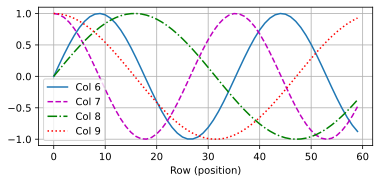

In [3]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
     figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

# Transformer
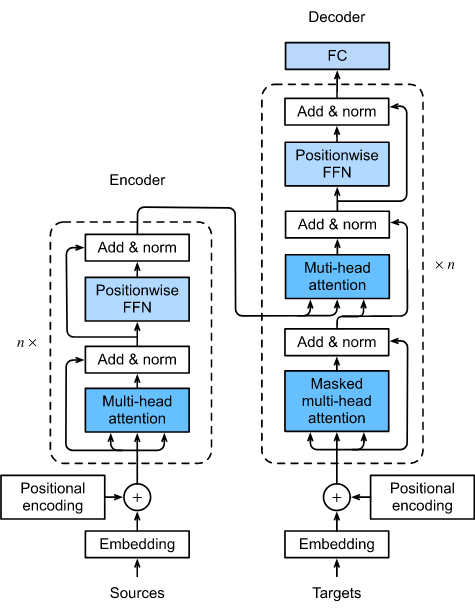

## Positionwise Feed-Forward Networks

In [4]:
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [5]:
ffn = PositionWiseFFN(4, 8)
print(ffn(torch.ones((2, 3, 4))).shape)
print(ffn.eval())
ffn(torch.ones((2, 3, 4)))[0]

torch.Size([2, 3, 8])
PositionWiseFFN(
  (dense1): Linear(in_features=4, out_features=4, bias=True)
  (relu): ReLU()
  (dense2): Linear(in_features=4, out_features=8, bias=True)
)


/home/nancy/.local/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


tensor([[ 0.0363,  0.0872,  0.4626, -0.2489, -0.3172, -0.4407,  0.4713, -0.1797],
        [ 0.0363,  0.0872,  0.4626, -0.2489, -0.3172, -0.4407,  0.4713, -0.1797],
        [ 0.0363,  0.0872,  0.4626, -0.2489, -0.3172, -0.4407,  0.4713, -0.1797]],
       grad_fn=<SelectBackward0>)

In [6]:
X = torch.ones((2, 3, 4))
nn.ReLU()(nn.LazyLinear(5)(X)).shape

torch.Size([2, 3, 5])

## Residual Connection and Layer Normalization

Compares the normalization across different dimensions by layer normalization and batch normalization.

In [7]:
ln = nn.LayerNorm(2)
bn = nn.LazyBatchNorm1d()
X = torch.tensor([[1, 2], [3, 4]], dtype=torch.float32)
print('layer norm:', ln(X))
print('batch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>)
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


AddNorm class using a residual connection followed by layer normalization. Dropout is also applied for regularization.

In [2]:
class AddNorm(nn.Module):
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        # The residual connection followed by layer normalization.
        return self.ln(self.dropout(Y) + X)

The residual connection requires that the two inputs are of the same shape so that the output tensor also has the same shape after the addition operation.

In [9]:
add_norm = AddNorm(4, 0.5)
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

## Encoder

`TransformerEncoderBlock` class contains two sublayers: **multi-head self-attention** and **positionwise feed-forward networks**, where a **residual connection** followed by **layer normalization** is employed around both sublayers.

In [3]:
class TransformerEncoderBlock(nn.Module):
    """The Transformer encoder block."""

    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias=False):
        super().__init__()
        self.attention = MultiHeadAttention(
            num_hiddens, num_heads, dropout, use_bias)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

Any layer in the Transformer encoder does not change the shape of its input.

In [11]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = TransformerEncoderBlock(24, 48, 8, 0.5)
print(encoder_blk(X, valid_lens).shape)
encoder_blk.eval()

torch.Size([2, 100, 24])


TransformerEncoderBlock(
  (attention): MultiHeadAttention(
    (attention): DotProductAttention(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (W_q): Linear(in_features=24, out_features=24, bias=False)
    (W_k): Linear(in_features=24, out_features=24, bias=False)
    (W_v): Linear(in_features=24, out_features=24, bias=False)
    (W_o): Linear(in_features=24, out_features=24, bias=False)
  )
  (addnorm1): AddNorm(
    (dropout): Dropout(p=0.5, inplace=False)
    (ln): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
  )
  (ffn): PositionWiseFFN(
    (dense1): Linear(in_features=24, out_features=48, bias=True)
    (relu): ReLU()
    (dense2): Linear(in_features=48, out_features=24, bias=True)
  )
  (addnorm2): AddNorm(
    (dropout): Dropout(p=0.5, inplace=False)
    (ln): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
  )
)

Stack `num_blks` instances of the above `TransformerEncoderBlock` classes. 

Since we use the **fixed positional encoding** whose values are always between -1 and 1, we multiply values of the learnable input embeddings by the square root of the embedding dimension to *rescale* before summing up the input embedding and the positional encoding.

In [4]:
class TransformerEncoder(Encoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, use_bias=False):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias))

    def forward(self, X, valid_lens):
        # # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

 The shape of the Transformer encoder output is (batch size, number of time steps, num_hiddens).

In [13]:
encoder = TransformerEncoder(vocab_size=200, num_hiddens=24,
                             ffn_num_hiddens=48, num_heads=8,
                             num_blks=2, dropout=0.5)
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

In [14]:
encoder.eval()

TransformerEncoder(
  (embedding): Embedding(200, 24)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (blks): Sequential(
    (block0): TransformerEncoderBlock(
      (attention): MultiHeadAttention(
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.5, inplace=False)
        )
        (W_q): Linear(in_features=24, out_features=24, bias=False)
        (W_k): Linear(in_features=24, out_features=24, bias=False)
        (W_v): Linear(in_features=24, out_features=24, bias=False)
        (W_o): Linear(in_features=24, out_features=24, bias=False)
      )
      (addnorm1): AddNorm(
        (dropout): Dropout(p=0.5, inplace=False)
        (ln): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
      )
      (ffn): PositionWiseFFN(
        (dense1): Linear(in_features=24, out_features=48, bias=True)
        (relu): ReLU()
        (dense2): Linear(in_features=48, out_features=24, bias=True)
      )
      (addnorm2): AddNorm(
   

In [15]:
X = torch.ones((2, 100), dtype=torch.long)
embeds = nn.Embedding(200, 24)(X)
embeds, embeds.shape

(tensor([[[-1.4208,  0.5068, -0.1508,  ..., -0.7008,  0.1010,  0.0486],
          [-1.4208,  0.5068, -0.1508,  ..., -0.7008,  0.1010,  0.0486],
          [-1.4208,  0.5068, -0.1508,  ..., -0.7008,  0.1010,  0.0486],
          ...,
          [-1.4208,  0.5068, -0.1508,  ..., -0.7008,  0.1010,  0.0486],
          [-1.4208,  0.5068, -0.1508,  ..., -0.7008,  0.1010,  0.0486],
          [-1.4208,  0.5068, -0.1508,  ..., -0.7008,  0.1010,  0.0486]],
 
         [[-1.4208,  0.5068, -0.1508,  ..., -0.7008,  0.1010,  0.0486],
          [-1.4208,  0.5068, -0.1508,  ..., -0.7008,  0.1010,  0.0486],
          [-1.4208,  0.5068, -0.1508,  ..., -0.7008,  0.1010,  0.0486],
          ...,
          [-1.4208,  0.5068, -0.1508,  ..., -0.7008,  0.1010,  0.0486],
          [-1.4208,  0.5068, -0.1508,  ..., -0.7008,  0.1010,  0.0486],
          [-1.4208,  0.5068, -0.1508,  ..., -0.7008,  0.1010,  0.0486]]],
        grad_fn=<EmbeddingBackward0>),
 torch.Size([2, 100, 24]))

In [16]:
pos_encoding = PositionalEncoding(24, 0.5)

In [17]:
pos_encoding(embeds * math.sqrt(24))

tensor([[[-13.9213,   6.9658,  -1.4779,  ...,  -0.0000,   0.9895,   2.4759],
         [ -0.0000,   6.0464,  -0.0000,  ...,  -4.8664,   0.9900,   2.4759],
         [-12.1027,   4.1335,   0.1233,  ...,  -0.0000,   0.9904,   2.4759],
         ...,
         [-13.1621,   3.1155,   0.0000,  ...,  -4.8684,   1.0313,   0.0000],
         [ -0.0000,   0.0000,   0.0000,  ...,  -0.0000,   0.0000,   0.0000],
         [ -0.0000,   0.0000,   0.0000,  ...,  -4.8685,   1.0322,   2.4754]],

        [[-13.9213,   0.0000,  -0.0000,  ...,  -0.0000,   0.0000,   0.0000],
         [-12.2383,   6.0464,  -0.5825,  ...,  -0.0000,   0.0000,   0.0000],
         [ -0.0000,   4.1335,   0.0000,  ...,  -4.8664,   0.0000,   0.0000],
         ...,
         [-13.1621,   0.0000,   0.2481,  ...,  -4.8684,   0.0000,   2.4754],
         [ -0.0000,   3.3272,   0.5178,  ...,  -0.0000,   0.0000,   2.4754],
         [ -0.0000,   5.0454,   0.0000,  ...,  -4.8685,   0.0000,   2.4754]]],
       grad_fn=<MulBackward0>)

## Decoder

`TransformerDecoderBlock` contains three sublayers: decoder self-attention, encoder-decoder attention, and positionwise feed-forward networks. These sublayers employ a residual connection around them followed by layer normalization.

In [2]:
class TransformerDecoderBlock(nn.Module):
    # The i-th block in the Transformer decoder
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = MultiHeadAttention(num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = MultiHeadAttention(num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so state[2][self.i] is None as initialized. When
        # decoding any output sequence token by token during prediction,
        # state[2][self.i] contains representations of the decoded output at
        # the i-th block up to the current time step
        if state[2][self.i] is None:
            # the q,k,v of the 1st attention are all X
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)

        state[2][self.i] = key_values
        # At any decoder time step only the generated tokens can be used in the decoder self-attention.
        # To preserve auto-regression in the decoder,
        # its masked self-attention specifies dec_valid_lens so that
        # any query only attends to all positions in the decoder up to the query position.
        if self.training:
            batch_size, num_steps, _ = X.shape
            # dec_valid_lens: (batch_size, num_steps),
            # where every row is [1, 2, ..., num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps+1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention.
        # enc_outputs:(batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [6]:
decoder_blk = TransformerDecoderBlock(24, 48, 8, 0.5, 0)
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

/home/nancy/.local/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


NameError: name 'encoder_blk' is not defined

In [3]:
class TransformerDecoder(Decoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerDecoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.LazyLinear(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * self.num_blks for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][i]=blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][i]=blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

## Training

In [19]:
data = MTFraEng(batch_size=128)
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4

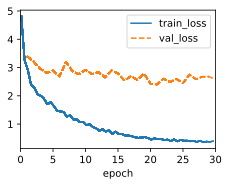

In [9]:
encoder = TransformerEncoder(len(data.src_vocab), num_hiddens, 
                             ffn_num_hiddens, num_heads, num_blks, dropout)
decoder = TransformerDecoder(len(data.tgt_vocab), num_hiddens, ffn_num_hiddens,
                             num_heads, num_blks, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.0015)
trainer = Trainer(max_epochs=30, gradient_clip_val=1)
trainer.fit(model, data)

### Prediction

In [12]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), cpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['elle', 'court', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


## Visualization
The shape of the encoder self-attention weights is (number of encoder layers, number of attention heads, num_steps or number of queries, num_steps or number of key-value pairs).

In [20]:
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), cpu(), data.num_steps, True)

In [24]:
model.encoder.attention_weights[0].shape

torch.Size([4, 9, 9])

In [25]:
enc_attention_weights = torch.cat(model.encoder.attention_weights, 0)
shape = (num_blks, num_heads, -1, data.num_steps)
enc_attention_weights = enc_attention_weights.reshape(shape)
enc_attention_weights.shape

torch.Size([2, 4, 9, 9])

In the encoder self-attention, both queries and keys come from the same input sequence. Since padding tokens do not carry meaning, with specified valid length of the input sequence, no query attends to positions of padding tokens. 

In the following, two layers of multi-head attention weights are presented row by row. Each head independently attends based on a separate representation subspaces of queries, keys, and values.

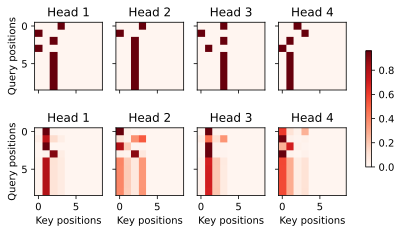

In [26]:
show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

In [27]:
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weights
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
shape = (-1, 2, num_blks, num_heads, data.num_steps)
dec_attention_weights = dec_attention_weights_filled.reshape(shape)
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)

In [31]:
dec_self_attention_weights.shape,dec_inter_attention_weights.shape

(torch.Size([2, 4, 9, 9]), torch.Size([2, 4, 9, 9]))

Due to the auto-regressive property of the decoder self-attention, no query attends to key-value pairs after the query position.

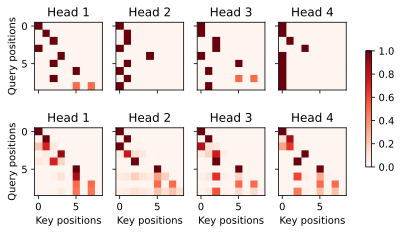

In [32]:
show_heatmaps(
    dec_self_attention_weights[:, :, :, :],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

Similar to the case in the encoder self-attention, via the specified valid length of the input sequence, no query from the output sequence attends to those padding tokens from the input sequence.

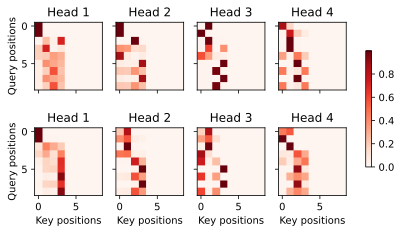

In [33]:
show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

# Transformers for Vision